## Time series modelling to forecast number of passengers with ARIMA, auto ARIMA and Xgboost 

In [167]:
import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

#from fbprophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

In [108]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [109]:
data['Month'].dtypes

dtype('O')

In [110]:
data['Month']= pd.to_datetime(data['Month'])

In [111]:
# Checking for null values
data.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [112]:
# Investigate all the elements whithin each Feature
for column in data:
    unique_vals = np.unique(data[column])
    nr_values = len(unique_vals)
    if nr_values < 36:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Month :144
The number of values for feature #Passengers :118


In [113]:
data['Month'].min()

Timestamp('1949-01-01 00:00:00')

In [114]:
data['Month'].max()

Timestamp('1960-12-01 00:00:00')

In [115]:
#splitting the data
X_train = data[data['Month'] < '1961-07']
X_valid = data[data['Month'] >= '1960-07']

print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train['Month'].unique()

X_train Shape (144, 2)
X_Valid Shape (6, 2)


array(['1949-01-01T00:00:00.000000000', '1949-02-01T00:00:00.000000000',
       '1949-03-01T00:00:00.000000000', '1949-04-01T00:00:00.000000000',
       '1949-05-01T00:00:00.000000000', '1949-06-01T00:00:00.000000000',
       '1949-07-01T00:00:00.000000000', '1949-08-01T00:00:00.000000000',
       '1949-09-01T00:00:00.000000000', '1949-10-01T00:00:00.000000000',
       '1949-11-01T00:00:00.000000000', '1949-12-01T00:00:00.000000000',
       '1950-01-01T00:00:00.000000000', '1950-02-01T00:00:00.000000000',
       '1950-03-01T00:00:00.000000000', '1950-04-01T00:00:00.000000000',
       '1950-05-01T00:00:00.000000000', '1950-06-01T00:00:00.000000000',
       '1950-07-01T00:00:00.000000000', '1950-08-01T00:00:00.000000000',
       '1950-09-01T00:00:00.000000000', '1950-10-01T00:00:00.000000000',
       '1950-11-01T00:00:00.000000000', '1950-12-01T00:00:00.000000000',
       '1951-01-01T00:00:00.000000000', '1951-02-01T00:00:00.000000000',
       '1951-03-01T00:00:00.000000000', '1951-04-01

## FORECASTING WITH ARIMA

In [116]:
# filtering the train data
X_train2 = X_train[['Month', '#Passengers']]

#filtering the valid data
X_valid2 = X_valid[['Month', '#Passengers']]

# set the date into index
X_train2.set_index('Month', inplace=True)
X_valid2.set_index('Month', inplace=True)

# Setting the Index for 6 years
index_6_years = pd.date_range(X_train2.index[-1], freq='AS', periods = 6) 

index_6_years

DatetimeIndex(['1961-01-01', '1962-01-01', '1963-01-01', '1964-01-01',
               '1965-01-01', '1966-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [117]:
len(X_valid2['#Passengers'])

6

In [118]:
len(fcast1.values)

6

The MSE of ARIMA is: 209.64375655831967


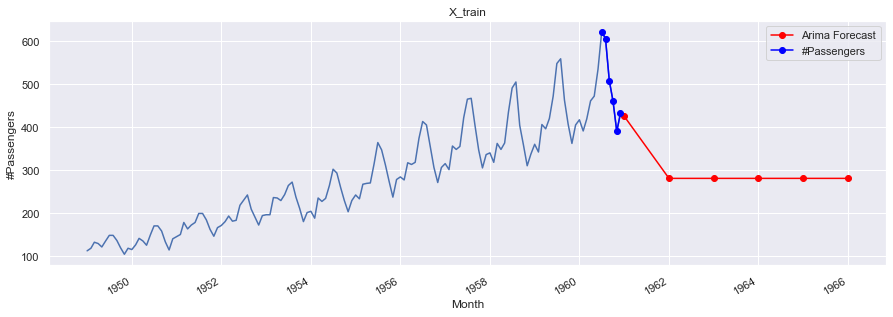

In [119]:
# Running ARIMA with default values
model_arima = ARIMA(X_train2, order=(0,0,1)) 
model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(6)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_6_years)
fcast1 = fcast1.rename("Arima Forecast") 

# Plotting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='Month', y='#Passengers', data = X_train)
chart.set_title('X_train')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
X_valid2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the mean squared error
print('The MSE of ARIMA is:', mean_squared_error(X_valid2['#Passengers'].values, fcast1.values, squared=False))

In [120]:
#hyperparameter tuning of ARIMA manually 
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = ARIMA(X_train2,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 1790.3675804181141
(0, 0, 1) 1618.8625269862202
(0, 1, 0) 1415.2775866746063
(0, 1, 1) 1398.8271098115247
(0, 1, 2) 1398.3855317873042
(0, 1, 3) 1381.664307188424
(0, 1, 4) 1357.3148898623438
(0, 2, 0) 1452.5901607647536
(0, 2, 1) 1413.3627088342669
(0, 2, 2) 1396.3716957493396
(0, 2, 3) 1396.4082541081605
(0, 2, 4) 1380.466268049941
(1, 0, 0) 1428.1793789210942
(1, 0, 1) 1409.7482702916636
(1, 0, 2) 1411.0502543255159
(1, 0, 3) 1412.7064505864726
(1, 0, 4) 2322.35962606869
(1, 1, 0) 1403.4728609589101
(1, 1, 1) 1402.1453998022516
(1, 1, 2) 1371.8153739092716
(1, 1, 3) 1373.0757022081173
(1, 1, 4) 1359.1666013284196
(1, 2, 0) 1449.0260024226097
(1, 2, 2) 1393.9084415091488
(1, 2, 3) 1394.4667292538188
(1, 2, 4) 1396.2168206451033
(2, 0, 0) 1413.6387841276005
(2, 0, 1) 1408.2492233855835
(2, 0, 2) 1409.1024734658308
(2, 0, 3) 1435.4830066884697
(2, 0, 4) 1397.406676199212
(2, 1, 0) 1397.9751521795574
(2, 1, 1) 1361.6958173667952
(2, 1, 2) 1344.0434377245442
(2, 1, 3) 1343.2782

The MSE of ARIMA is: 130.7217342533064


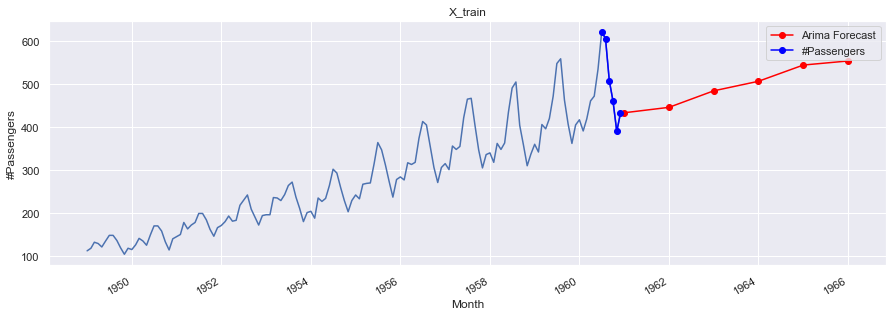

In [121]:
# Running ARIMA with the best value
model_arima = ARIMA(X_train2, order=(4, 1, 4)) 
model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(6)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_6_years)
fcast1 = fcast1.rename("Arima Forecast") 

# Plotting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='Month', y='#Passengers', data = X_train)
chart.set_title('X_train')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
X_valid2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the mean squared error
print('The MSE of ARIMA is:', mean_squared_error(X_valid2['#Passengers'].values, fcast1.values, squared=False))

The MSE of ARIMA is: 130.7217342533064


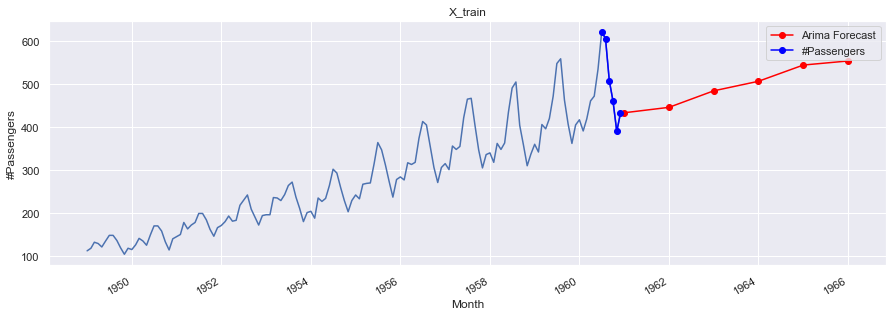

In [122]:
# Hyperparamter tuning of ARIMA using auto ARIMA 
auto_arima_model = pm.auto_arima(X_train2, seasonal=False, m=6)

# make your forecasts
fcast2 = auto_arima_model.predict(6) 
fcast2 = pd.Series(fcast2, index=index_6_years)
fcast2 = fcast2.rename("Auto Arima")

# Plotting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='Month', y='#Passengers', data = X_train)
chart.set_title('X_train')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
X_valid2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the mean squared error
print('The MSE of ARIMA is:', mean_squared_error(X_valid2['#Passengers'].values, fcast1.values, squared=False))

#### Manually picking the hyperaramter gave a better MSE than the auto arima did, and it better forecasts the number of passengers

## XGBOOST

In [134]:
import xgboost
from xgboost import XGBRegressor

In [123]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

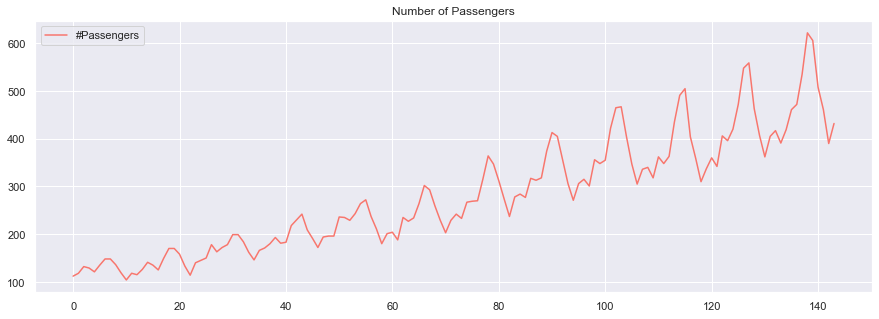

In [124]:
_ = data.drop(columns=['Month']).plot(style='-', figsize=(15,5), color=color_pal[0], title='Number of Passengers')

In [125]:
data['Month'].head()

0   1949-01-01
1   1949-02-01
2   1949-03-01
3   1949-04-01
4   1949-05-01
Name: Month, dtype: datetime64[ns]

In [126]:
xg_train = data[data['Month'] < '1958-01-01']
xg_valid= data[data['Month'] >= '1958-01-01']

In [127]:
xg_train.shape

(108, 2)

In [128]:
xg_valid.shape

(36, 2)

In [129]:
xg_train = xg_train.set_index('Month')
xg_valid = xg_valid.set_index('Month')

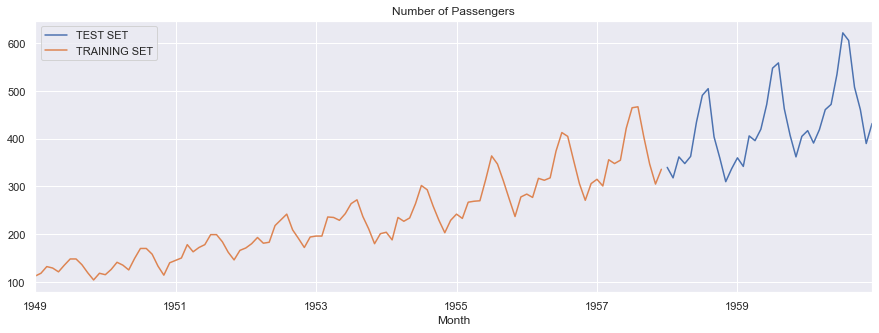

In [131]:
_ = xg_valid \
    .rename(columns={'#Passengers': 'TEST SET'}) \
    .join(xg_train.rename(columns={'#Passengers': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Number of Passengers', style='-')


In [142]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    
    X = df[['month','year',
           'dayofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [143]:
X_train, y_train = create_features(xg_train, label='#Passengers')
X_test, y_test = create_features(xg_valid, label='#Passengers')

In [144]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108, 3)
(36, 3)
(108,)
(36,)


In [181]:
xg = XGBRegressor(max_depth=7,n_estimators=70)
xg.fit(X_train,y_train)
xg_pred = xg.predict(X_test)

[18:29:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [182]:
xg_valid['#Passengers_forecasting'] = xg.predict(X_test)
data_all = pd.concat([xg_valid, xg_train], sort=False)

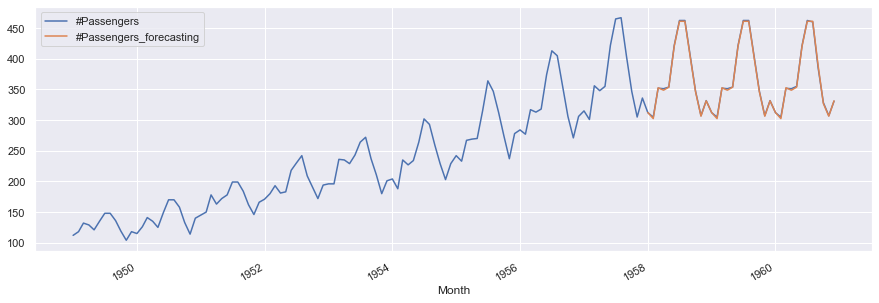

In [183]:
_ = data_all[['#Passengers','#Passengers_forecasting']].plot(figsize=(15, 5))

In [184]:
data_all['date'].min()

Timestamp('1949-01-01 00:00:00')

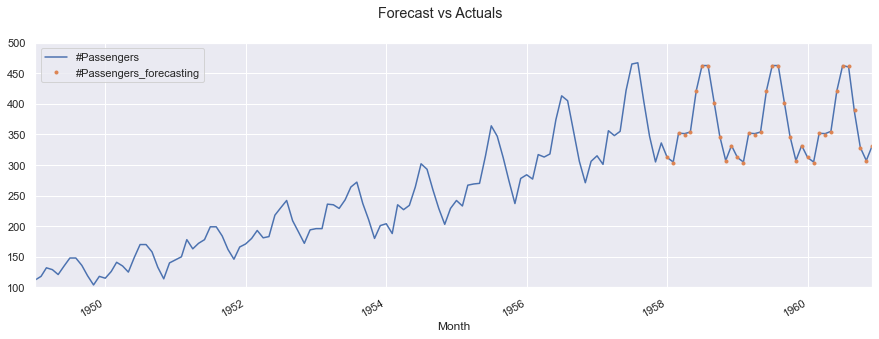

In [185]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['#Passengers','#Passengers_forecasting']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='1949-01-01 00:00:00', upper='1960-12-01 00:00:00')
ax.set_ylim(100, 500)
plot = plt.suptitle('Forecast vs Actuals')


In [188]:
print('Root Mean Squared error is :',np.sqrt(mean_squared_error(y_test,xg_pred)))

Root Mean Squared error is : 76.78446774889157


In [187]:
print('Mean Absolute error is :',mean_absolute_error(y_test,xg_pred))

Mean Absolute error is : 62.84887271457248
